In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Define CNN Encoder

In [ ]:
import torch
import torch.nn as nn

class SimpleEncoderV2(nn.Module):
    def __init__(self):
        super().__init__()

       # Conv → BN → ReLU → Conv → BN → ReLU
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.encoder = nn.Sequential(
            block(3, 32),
            nn.MaxPool2d(2),     # 224 -> 112

            block(32, 64),
            nn.MaxPool2d(2),     # 112 -> 56

            block(64, 128),
            nn.MaxPool2d(2),     # 56 -> 28

            block(128, 256),
            nn.MaxPool2d(2),     # 28 -> 14

            block(256, 256),     # EXTRA block without pooling
        )

        # Replace huge flatten with efficient pooling
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        # Final feature vector (256-d)
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        x = self.encoder(x)              # [B, 256, H, W]
        x = self.pool(x)                 # [B, 256, 1, 1]
        x = x.squeeze(-1).squeeze(-1)    # [B, 256]
        h = self.fc(x)                   # [B, 256]
        return h


## Augmentation pipeline and Train Dataloader

In [ ]:
from torchvision import transforms

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),   # stronger crop
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.8,
        contrast=0.8,
        saturation=0.8,
        hue=0.2
    ),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.8,
            contrast=0.8,
            saturation=0.8,
            hue=0.2
        )
    ], p=0.8),

    transforms.RandomGrayscale(p=0.2),

    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),

    transforms.ToTensor(),
])


class SimCLRDataset(Dataset):
    def __init__(self, folder, transform):
        self.base = datasets.ImageFolder(folder, transform=None)
        self.transform = transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]
        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj

train_dataset_simclr = SimCLRDataset("cvd/train", simclr_transform)

train_loader = DataLoader(
    train_dataset_simclr,
    batch_size=16,       # TRY BIGGER SIZE LATER !!!!!!
    shuffle=True,
    num_workers=4,
    drop_last=True       # not divisible by 16
)


## Projection Head Neural Network 

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=256, hidden_dim=512, out_dim=128):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)
class SimCLR(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder                     # mota wala CNN
        self.projector = ProjectionHead(256, 512, 128)

    def forward(self, x):
        h = self.encoder(x)  
        z = self.projector(h)  
        return h, z


## Loss function

In [5]:
import torch.nn.functional as F

def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)

    z = torch.cat([z_i, z_j], dim=0)
    sim = torch.mm(z, z.t())
    sim = sim / temperature

    mask = ~torch.eye(2*N, dtype=bool).to(device)

    positives = torch.cat([torch.diag(sim, N), torch.diag(sim, -N)])
    negatives = sim[mask].view(2*N, -1)

    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
    labels = torch.zeros(2*N, dtype=torch.long).to(device)

    loss = F.cross_entropy(logits, labels)
    return loss


In [6]:
# encoder = SimpleEncoderV2().to(device)
# proj = ProjectionHead(in_dim=256, out_dim=128).to(device)

# model = SimCLR(encoder).to(device)
# model.load_state_dict(torch.load(f="models/simclr_epoch_140.pth"))

## Training

In [7]:

# optimizer = optim.Adam(model.parameters(), lr=3e-4)
# epochs = 200

# for epoch in tqdm(range(141,epochs)):
#     model.train()
#     total_loss = 0

#     for xi, xj in train_loader:
#         xi, xj = xi.to(device), xj.to(device)

#         _, zi = model(xi)
#         _, zj = model(xj)

#         loss = nt_xent_loss(zi, zj)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(train_loader):.4f}")

#     # Save model every 10 epochs (outside inner loop)
#     if (epoch + 1) % 10 == 0:
#         torch.save(model.state_dict(), f"models/simclr_epoch_{epoch+1}.pth")
#         print(f"Saved checkpoint at epoch {epoch+1}")


## Evaluation Stuff

### Accuracy vs Epoch

In [7]:
encoder = SimpleEncoderV2().to(device)
proj = ProjectionHead(in_dim=256, out_dim=128).to(device)

model = SimCLR(encoder).to(device)
model.load_state_dict(torch.load(f="models/simclr_epoch_180.pth"))
encoder=model.encoder
encoder.eval()
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder("cvd/test", transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
len(test_loader)

156

In [10]:
encoder.eval()
features = []
labels = []

with torch.no_grad():
    for imgs, y in test_loader:
        imgs = imgs.to(device)
        h, _ = model(imgs)   # get encoder features, not projection
        features.append(h.cpu().numpy())
        labels.append(y.numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)


import pickle


features_pca = PCA(50).fit_transform(features)
kmeans = KMeans(2).fit_predict(features_pca)
a = accuracy_score(labels, kmeans)
b = accuracy_score(labels, 1-kmeans)
print("Accuracy:", max(a,b))

# pickle.dump(features_pca, open("models/pca.pkl", "wb"))

# # Save KMeans
# pickle.dump(kmeans, open("models/kmeans.pkl", "wb"))



Accuracy: 0.7325045117304994


In [12]:
accs=[] # will store [epoch , acc] to later plot for paper last section


for i in range(10,181,10):
    save_path= f"models/simclr_epoch_{i}.pth"
    encoder = SimpleEncoderV2().to(device)
    model = SimCLR(encoder).to(device)
    model.load_state_dict(torch.load(f=save_path))
    encoder=model.encoder
    encoder.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, y in test_loader:
            imgs = imgs.to(device)
            h, _ = model(imgs)   # get encoder features, not projection
            features.append(h.cpu().numpy())
            labels.append(y.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    features_pca = PCA(50).fit_transform(features)
    kmeans = KMeans(2).fit_predict(features_pca)
    a = accuracy_score(labels, kmeans)
    b = accuracy_score(labels, 1-kmeans)
    print(f"Accuracy on epoch: {i} is {max(a,b)*100}")
    accs.append([i,max(a,b)])

Accuracy on epoch: 10 is 51.03268498095047
Accuracy on epoch: 20 is 51.31341487868458
Accuracy on epoch: 30 is 52.456386605173456
Accuracy on epoch: 40 is 57.589733306597154
Accuracy on epoch: 50 is 59.63505113294566
Accuracy on epoch: 60 is 53.55925406055745
Accuracy on epoch: 70 is 64.18688590334871
Accuracy on epoch: 80 is 66.19209945859234
Accuracy on epoch: 90 is 66.6131943051935
Accuracy on epoch: 100 is 69.24002406256267
Accuracy on epoch: 110 is 68.85903348706637
Accuracy on epoch: 120 is 70.22257870463204
Accuracy on epoch: 130 is 70.24263084018449
Accuracy on epoch: 140 is 70.08221375576498
Accuracy on epoch: 150 is 69.68117104471627
Accuracy on epoch: 160 is 74.25305795067175
Accuracy on epoch: 170 is 73.04992981752557
Accuracy on epoch: 180 is 73.25045117304994


In [13]:
accs

[[10, 0.5103268498095047],
 [20, 0.5131341487868458],
 [30, 0.5245638660517346],
 [40, 0.5758973330659716],
 [50, 0.5963505113294566],
 [60, 0.5355925406055745],
 [70, 0.6418688590334871],
 [80, 0.6619209945859234],
 [90, 0.666131943051935],
 [100, 0.6924002406256267],
 [110, 0.6885903348706637],
 [120, 0.7022257870463204],
 [130, 0.7024263084018448],
 [140, 0.7008221375576499],
 [150, 0.6968117104471626],
 [160, 0.7425305795067174],
 [170, 0.7304992981752557],
 [180, 0.7325045117304994]]

In [14]:
import pickle

# save
with open("accs.pkl", "wb") as f:
    pickle.dump(accs, f)

# load later


In [15]:
with open("accs.pkl", "rb") as f:
    accs= pickle.load(f)

accs

[[10, 0.5103268498095047],
 [20, 0.5131341487868458],
 [30, 0.5245638660517346],
 [40, 0.5758973330659716],
 [50, 0.5963505113294566],
 [60, 0.5355925406055745],
 [70, 0.6418688590334871],
 [80, 0.6619209945859234],
 [90, 0.666131943051935],
 [100, 0.6924002406256267],
 [110, 0.6885903348706637],
 [120, 0.7022257870463204],
 [130, 0.7024263084018448],
 [140, 0.7008221375576499],
 [150, 0.6968117104471626],
 [160, 0.7425305795067174],
 [170, 0.7304992981752557],
 [180, 0.7325045117304994]]

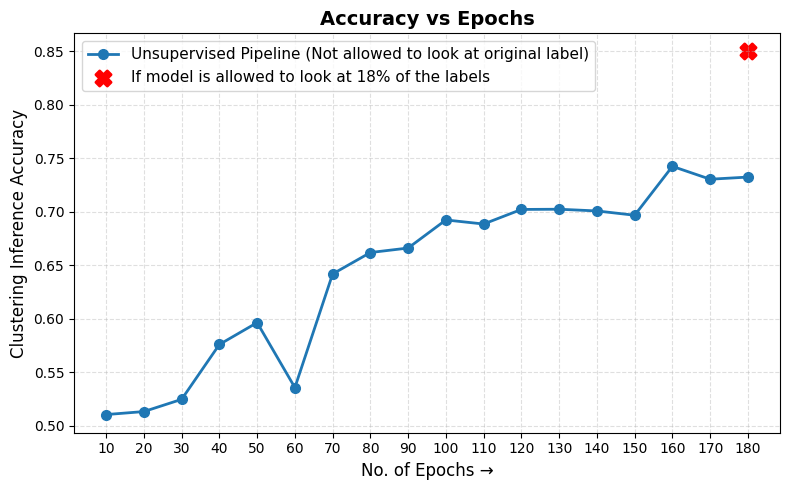

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

accs = np.array(accs)

plt.figure(figsize=(8,5))

plt.plot(
    accs[:,0], accs[:,1],
    marker='o',
    markersize=7,
    linewidth=2,
    label="Unsupervised Pipeline (Not allowed to look at original label)"
)


ss_epoch = 180     
ss_acc = 0.85       

plt.scatter(
    ss_epoch,
    ss_acc,
    s=120,               
    marker='X',           
    linewidth=2,
    label="If model is allowed to look at 18% of the labels",
    color='red'
)


plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("No. of Epochs →", fontsize=12)
plt.ylabel("Clustering Inference Accuracy", fontsize=12)
plt.title("Accuracy vs Epochs", fontsize=14, fontweight='bold')
plt.xticks(accs[:,0]) 
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


### tsne

Accuracy: 0.734509725285743


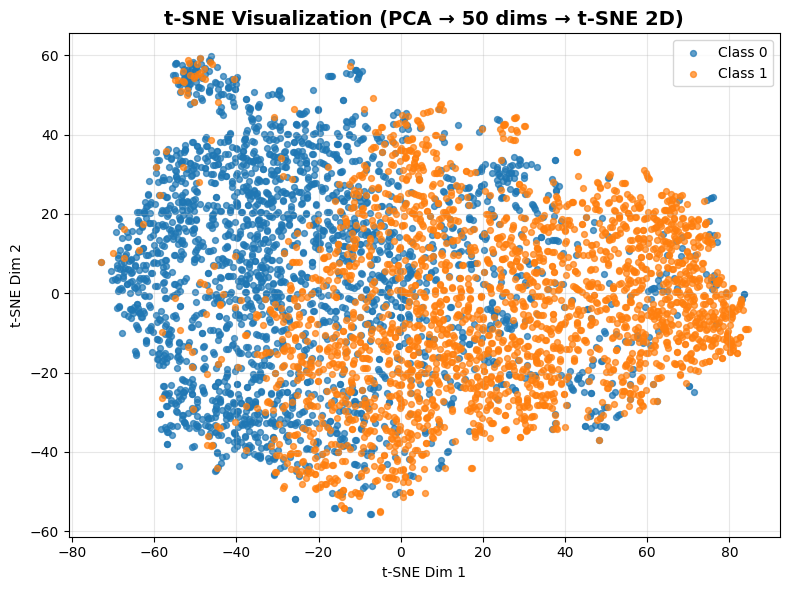

In [ ]:
encoder = SimpleEncoderV2().to(device)
model = SimCLR(encoder).to(device)
model.load_state_dict(torch.load("models/simclr_epoch_180.pth"))
encoder = model.encoder
encoder.eval()

features = []   
labels = []

with torch.no_grad():
    for imgs, y in test_loader:
        imgs = imgs.to(device)
        
        
        h = encoder(imgs)          
        h = h.view(h.size(0), -1)  
        features.append(h.cpu().numpy())
        labels.append(y.numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)





features_50 = PCA(50).fit_transform(features)
kmeans = KMeans(2).fit_predict(features_50)
a = accuracy_score(labels, kmeans)
b = accuracy_score(labels, 1-kmeans)
print("Accuracy:", max(a,b))




















from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


pca = PCA(n_components=50)
features_50 = pca.fit_transform(features)


tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    init='random',
    random_state=42
)
features_2d = tsne.fit_transform(features_50)

plt.figure(figsize=(8,6))

plt.scatter(
    features_2d[labels == 0, 0],
    features_2d[labels == 0, 1],
    s=18,
    alpha=0.7,
    label="Class 0"
)

plt.scatter(
    features_2d[labels == 1, 0],
    features_2d[labels == 1, 1],
    s=18,
    alpha=0.7,
    label="Class 1"
)

plt.title("t-SNE Visualization (PCA → 50 dims → t-SNE 2D)", fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Internal metrics

In [ ]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    accuracy_score
)


acc_a = accuracy_score(labels, kmeans)
acc_b = accuracy_score(labels, 1-kmeans)
kmeans_final = kmeans if acc_a >= acc_b else 1 - kmeans

print("K-Means Accuracy:", max(acc_a, acc_b))


sil = silhouette_score(features_50, kmeans_final)
print("Silhouette Score:", sil)


ch = calinski_harabasz_score(features_50, kmeans_final)
print("Calinski-Harabasz Score:", ch)


db = davies_bouldin_score(features_50, kmeans_final)
print("Davies-Bouldin Score:", db)


ari = adjusted_rand_score(labels, kmeans_final)
print("Adjusted Rand Index:", ari)


K-Means Accuracy: 0.734509725285743
Silhouette Score: 0.10519775748252869
Calinski-Harabasz Score: 621.3925170898438
Davies-Bouldin Score: 2.6003211360684553
Adjusted Rand Index: 0.2198369023095394
